<a href="https://colab.research.google.com/github/Ry02024/24DXbyLifeIsTech/blob/main/%E8%AA%B2%E9%A1%8C04/%E8%AA%B2%E9%A1%8C04%EF%BC%88%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 本番

## ライブラリのインポート

In [ ]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd

## データの読み込み

In [ ]:
!git clone https://github.com/Ry02024/24DXbyLifeIsTech.git

Cloning into '24DXbyLifeIsTech'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 140 (delta 45), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 17.26 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
data_dir = "/content/24DXbyLifeIsTech/Data/preprocessed"

In [ ]:
ls {data_dir}

data_sales_preprocessed2.csv  data_sales_preprocessed.csv  data_survey_preprocessed.csv


In [ ]:
sales_data = pd.read_csv(f"{data_dir}/data_sales_preprocessed2.csv")

## 関数

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# データの前処理
def preprocess_data(sales_data):
    data = sales_data.copy()

    # '取引日時' を datetime 型に変換
    data['取引日時'] = pd.to_datetime(data['取引日時'])

    # 年, 月, 日, 時間を抽出
    data['年'] = data['取引日時'].dt.year
    data['月'] = data['取引日時'].dt.month
    data['日'] = data['取引日時'].dt.day
    data['時間'] = data['取引日時'].dt.hour

    # '取引日時'から正しい '日付' 列を再生成
    data['日付'] = data['取引日時']

    return data


# COVID-19イベント期間の設定
def set_covid_periods():
    covid_events = [
        {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
        {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
        {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
        {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
        {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
    ]

    for event in covid_events:
        event['start'] = pd.to_datetime(event['start'])
        event['end'] = pd.to_datetime(event['end'])
    return covid_events

# COVID-19期間に絞ったデータの抽出
def filter_covid_data(data, start_date, end_date):
    data['日付'] = pd.to_datetime(data['日付'])
    covid_period_data = data[(data['日付'] >= start_date) & (data['日付'] <= end_date)]
    return covid_period_data

# データの時系列分割
def split_data(data, split_ratio=0.7):
    sorted_data = data.sort_values(by='日付')
    split_index = int(len(sorted_data) * split_ratio)
    train_data = sorted_data.iloc[:split_index]
    test_data = sorted_data.iloc[split_index:]
    return train_data, test_data

# ラベルエンコーディング
def label_encode_data(data, columns):
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    return data, label_encoders

# LightGBMモデルの訓練
def train_lightgbm(X_train, y_train, X_test, y_test, params):
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)
    callbacks = [
        lgb.log_evaluation(period=100),
        lgb.early_stopping(stopping_rounds=500, verbose=True)
    ]
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        num_boost_round=1000,
        callbacks=callbacks
    )
    return model

# モデルによる予測
def predict_sales(model, X_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    return y_pred

# 売上の計算
def calculate_sales(X_test, y_pred, item_price_column='商品単価'):
    X_test['売上'] = y_pred * X_test[item_price_column]
    total_sales = X_test['売上'].sum()
    return total_sales

# 売上のグラフ表示
def plot_sales(actual_sales_all_period, actual_sales_test_period, events_df):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')
    plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='予測の売上', color='green')
    for _, event in events_df.iterrows():
        plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])
    plt.title('全期間の実際の売上と予測の売上の比較')
    plt.xlabel('日付')
    plt.ylabel('売上 (¥)')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 高単価サービスのシミュレーション
def simulate_price_increase(data, label_encoders, high_price_categories, price_increase_rate=1.1):
    for category in high_price_categories:
        if category in label_encoders['商品カテゴリ'].classes_:
            category_label = label_encoders['商品カテゴリ'].transform([category])[0]
            data.loc[data['商品カテゴリ'] == category_label, '商品単価'] *= price_increase_rate
    return data

# 高単価商品の売上比較
def compare_sales_before_after(data, pred_before, pred_after, item_price_column='商品単価'):
    sales_before = data[item_price_column] * pred_before
    sales_after = data[item_price_column] * pred_after
    sales_change = sales_after.sum() - sales_before.sum()
    return sales_before.sum(), sales_after.sum(), sales_change



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## モデル生成

In [ ]:
# ラベルエンコーディングの関数
def label_encode_data(data, columns):
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    return data, label_encoders

# データの準備
sales_data = preprocess_data(sales_data)

# COVID-19期間のデータを取得
covid_events = set_covid_periods()
start_of_covid = covid_events[0]['start']
end_of_covid = covid_events[-1]['end']
covid_data = filter_covid_data(sales_data, start_of_covid, end_of_covid)

# データを70%:30%に分割
train_data, test_data = split_data(covid_data)

# カテゴリ変数をラベルエンコーディング
train_data, label_encoders = label_encode_data(train_data, ['商品カテゴリ', '商品ID'])
test_data, _ = label_encode_data(test_data, ['商品カテゴリ', '商品ID'])  # テストデータもエンコード

# LightGBMのトレーニング
X_train = train_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)  # floatに変換
y_train = train_data['数量'].astype(float)
X_test = test_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)  # floatに変換
y_test = test_data['数量'].astype(float)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

model = train_lightgbm(X_train, y_train, X_test, y_test, params)

# 予測の実行
y_pred_test = predict_sales(model, X_test)

# 売上の計算
total_sales = calculate_sales(X_test, y_pred_test)

# 結果の表示
print(f"総売上: {total_sales:.2f}円")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 20444, number of used features: 7
[LightGBM] [Info] Start training from score 2.643172
Training until validation scores don't improve for 500 rounds
[100]	training's l1: 1.55666	valid_1's l1: 1.44276
[200]	training's l1: 1.52321	valid_1's l1: 1.47291
[300]	training's l1: 1.50827	valid_1's l1: 1.48037
[400]	training's l1: 1.49666	valid_1's l1: 1.49319
[500]	training's l1: 1.4842	valid_1's l1: 1.50958
Early stopping, best iteration is:
[36]	training's l1: 1.64436	valid_1's l1: 1.42243
総売上: 9511467.59円


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 20444, number of used features: 7
[LightGBM] [Info] Start training from score 2.643172
Training until validation scores don't improve for 500 rounds
[100]	training's l1: 1.55666	valid_1's l1: 1.44276
[200]	training's l1: 1.52321	valid_1's l1: 1.47291
[300]	training's l1: 1.50827	valid_1's l1: 1.48037
[400]	training's l1: 1.49666	valid_1's l1: 1.49319
[500]	training's l1: 1.4842	valid_1's l1: 1.50958
Early stopping, best iteration is:
[36]	training's l1: 1.64436	valid_1's l1: 1.42243


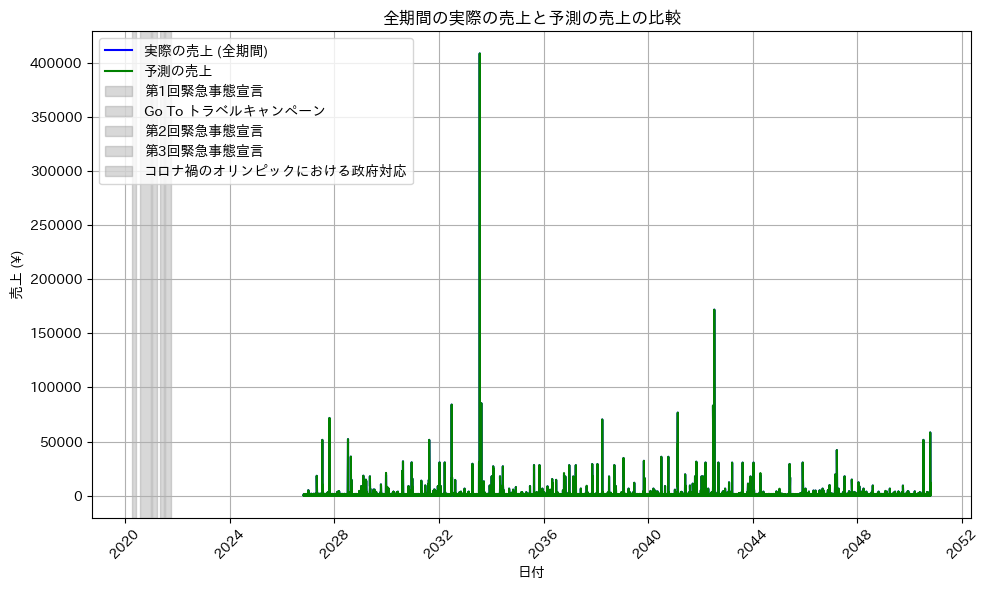

施策前の総売上: 9511467.59円
施策後の総売上: 9511068.38円
売上の増減: -399.21円


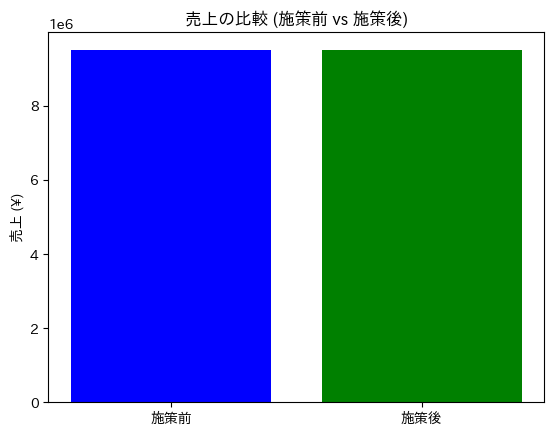

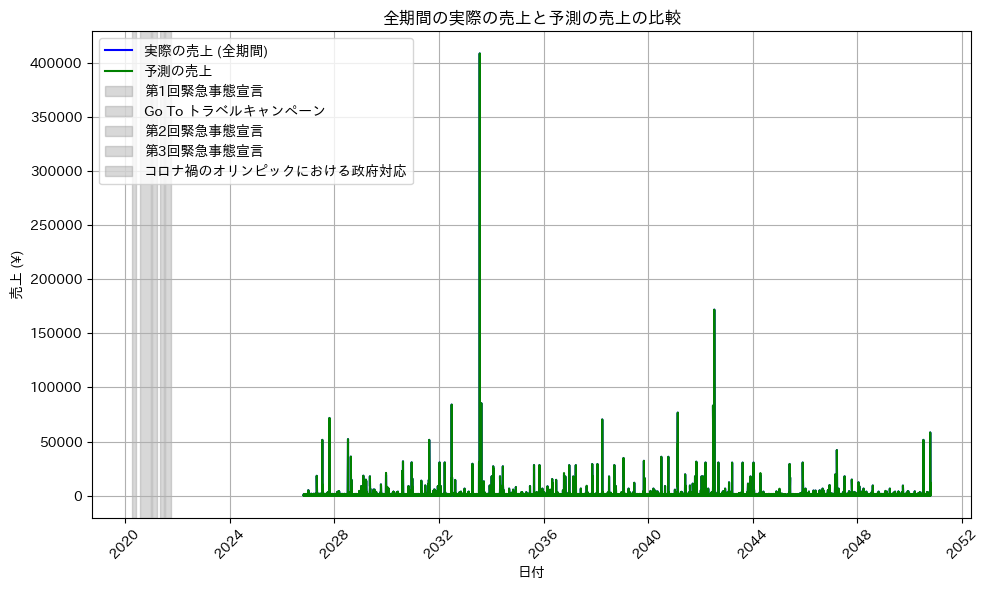

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# データの前処理関数
def preprocess_data(sales_data):
    data = sales_data.copy()
    data['年'] = pd.to_datetime(data['取引日時']).dt.year
    data['月'] = pd.to_datetime(data['取引日時']).dt.month
    data['日'] = pd.to_datetime(data['取引日時']).dt.day
    data['時間'] = pd.to_datetime(data['取引日時']).dt.hour
    return data

# COVID-19イベントの期間設定
def set_covid_periods():
    covid_events = [
        {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
        {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
        {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
        {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
        {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
    ]
    for event in covid_events:
        event['start'] = pd.to_datetime(event['start'])
        event['end'] = pd.to_datetime(event['end'])
    return covid_events

# データのフィルタリング
def filter_covid_data(data, start_date, end_date):
    data['日付'] = pd.to_datetime(data['日付'])
    covid_period_data = data[(data['日付'] >= start_date) & (data['日付'] <= end_date)]
    return covid_period_data

# データの時系列分割
def split_data(data, split_ratio=0.7):
    sorted_data = data.sort_values(by='日付')
    split_index = int(len(sorted_data) * split_ratio)
    train_data = sorted_data.iloc[:split_index]
    test_data = sorted_data.iloc[split_index:]
    return train_data, test_data

# ラベルエンコーディング
def label_encode_data(data, columns):
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    return data, label_encoders

# LightGBMモデルの訓練
def train_lightgbm(X_train, y_train, X_test, y_test, params):
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)
    callbacks = [
        lgb.log_evaluation(period=100),
        lgb.early_stopping(stopping_rounds=500, verbose=True)
    ]
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        num_boost_round=1000,
        callbacks=callbacks
    )
    return model

# モデルによる予測
def predict_sales(model, X_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    return y_pred

# 売上の計算
def calculate_sales(X_test, y_pred, item_price_column='商品単価'):
    X_test['売上'] = y_pred * X_test[item_price_column]
    total_sales = X_test['売上'].sum()
    return total_sales

# シミュレーションによる売上の比較と可視化
def plot_sales_comparison(before_sales, after_sales):
    labels = ['施策前', '施策後']
    sales_values = [before_sales, after_sales]

    plt.bar(labels, sales_values, color=['blue', 'green'])
    plt.title('売上の比較 (施策前 vs 施策後)')
    plt.ylabel('売上 (¥)')
    plt.show()

# 時系列売上のグラフ表示
def plot_sales(actual_sales_all_period, actual_sales_test_period, events_df):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')
    plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='予測の売上', color='green')
    for _, event in events_df.iterrows():
        plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])
    plt.title('全期間の実際の売上と予測の売上の比較')
    plt.xlabel('日付')
    plt.ylabel('売上 (¥)')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 高単価サービスのシミュレーション
def simulate_price_increase(data, label_encoders, high_price_categories, price_increase_rate=1.1):
    for category in high_price_categories:
        if category in label_encoders['商品カテゴリ'].classes_:
            category_label = label_encoders['商品カテゴリ'].transform([category])[0]
            data.loc[data['商品カテゴリ'] == category_label, '商品単価'] *= price_increase_rate
    return data

# 売上の比較
def compare_sales_before_after(data, pred_before, pred_after, item_price_column='商品単価'):
    sales_before = data[item_price_column] * pred_before
    sales_after = data[item_price_column] * pred_after
    sales_change = sales_after.sum() - sales_before.sum()
    return sales_before.sum(), sales_after.sum(), sales_change

# データの準備
sales_data = preprocess_data(sales_data)

# COVID-19期間のデータを取得
covid_events = set_covid_periods()
start_of_covid = covid_events[0]['start']
end_of_covid = covid_events[-1]['end']
covid_data = filter_covid_data(sales_data, start_of_covid, end_of_covid)

# データを70%:30%に分割
train_data, test_data = split_data(covid_data)

# カテゴリ変数をラベルエンコーディング
train_data, label_encoders = label_encode_data(train_data, ['商品カテゴリ', '商品ID'])
test_data, _ = label_encode_data(test_data, ['商品カテゴリ', '商品ID'])

# LightGBMモデルのパラメータ
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

# LightGBMのトレーニング
X_train = train_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)
y_train = train_data['数量'].astype(float)
X_test = test_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)
y_test = test_data['数量'].astype(float)

model = train_lightgbm(X_train, y_train, X_test, y_test, params)

# 売上予測
y_pred_test = predict_sales(model, X_test)

# 売上の計算
total_sales_before = calculate_sales(X_test, y_pred_test)

# 高単価商品の価格上昇シミュレーション
high_price_categories = ['ガイド', '撮影料']  # 仮のカテゴリ名
simulation_data = simulate_price_increase(X_test.copy(), label_encoders, high_price_categories)
# LightGBMで予測するために、シミュレーションデータの列を訓練データと一致させる
simulation_data = simulation_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)

# 価格上昇後の売上予測
y_pred_after = predict_sales(model, simulation_data)

# 売上の計算: 予測された数量に商品単価を掛ける
simulation_data['売上'] = y_pred_after * simulation_data['商品単価']

# 売上の計算結果を使ってグラフを描画
plot_sales(X_test['売上'], simulation_data['売上'], pd.DataFrame(covid_events))

# 売上の比較と結果表示
sales_before, sales_after, sales_change = compare_sales_before_after(X_test, y_pred_test, y_pred_after)
print(f"施策前の総売上: {sales_before:.2f}円")
print(f"施策後の総売上: {sales_after:.2f}円")
print(f"売上の増減: {sales_change:.2f}円")

# 売上の比較を可視化
plot_sales_comparison(sales_before, sales_after)

# 時系列売上のグラフ表示
plot_sales(X_test['売上'], simulation_data['売上'], pd.DataFrame(covid_events))


## 全体1

<ipython-input-10-b0f0886ec914>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 20444, number of used features: 7
[LightGBM] [Info] Start training from score 2.643172
Training until validation scores don't improve for 500 rounds
[100]	training's l1: 1.55666	valid_1's l1: 1.44276
[200]	training's l1: 1.52321	valid_1's l1: 1.47291
[300]	training's l1: 1.50827	valid_1's l1: 1.48037
[400]	training's l1: 1.49666	valid_1's l1: 1.49319
[500]	training's l1: 1.4842	valid_1's l1: 1.50958
Early stopping, best iteration is:
[36]	training's l1: 1.64436	valid_1's l1: 1.42243
施策前の総売上: 9511467.59円
施策後の総売上: 9511068.38円
売上の増減: -399.21円


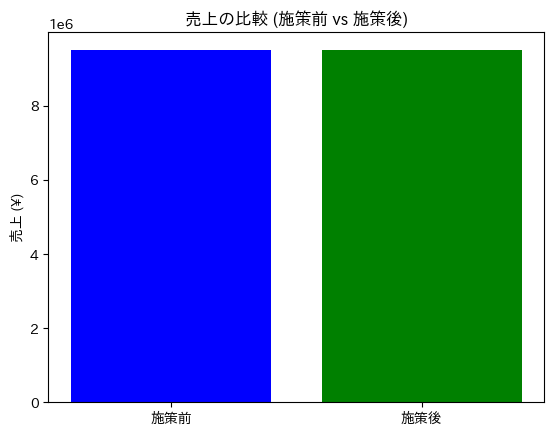

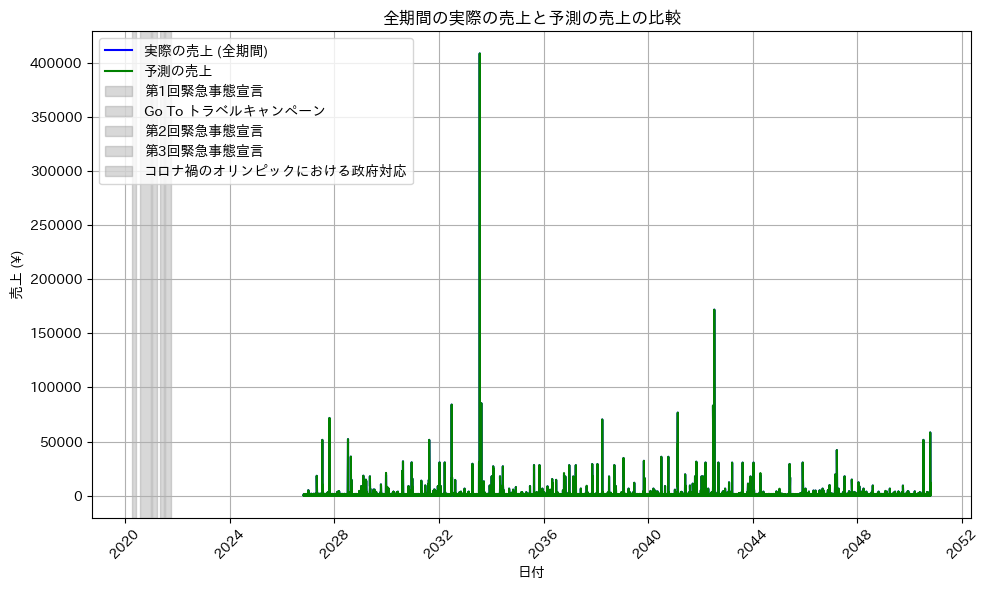

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# データの前処理関数
def preprocess_data(sales_data):
    data = sales_data.copy()

    # '取引日時' を datetime 型に変換
    data['取引日時'] = pd.to_datetime(data['取引日時'])

    # 年, 月, 日, 時間を抽出
    data['年'] = data['取引日時'].dt.year
    data['月'] = data['取引日時'].dt.month
    data['日'] = data['取引日時'].dt.day
    data['時間'] = data['取引日時'].dt.hour

    # '取引日時'から正しい '日付' 列を再生成
    data['日付'] = data['取引日時']

    return data

# COVID-19イベントの期間設定
def set_covid_periods():
    covid_events = [
        {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
        {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
        {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
        {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
        {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
    ]
    for event in covid_events:
        event['start'] = pd.to_datetime(event['start'])
        event['end'] = pd.to_datetime(event['end'])
    return covid_events

# データのフィルタリング
def filter_covid_data(data, start_date, end_date):
    covid_period_data = data[(data['日付'] >= start_date) & (data['日付'] <= end_date)]
    return covid_period_data

# データの時系列分割
def split_data(data, split_ratio=0.7):
    sorted_data = data.sort_values(by='日付')
    split_index = int(len(sorted_data) * split_ratio)
    train_data = sorted_data.iloc[:split_index]
    test_data = sorted_data.iloc[split_index:]
    return train_data, test_data

# ラベルエンコーディング
def label_encode_data(data, columns):
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    return data, label_encoders

# LightGBMモデルの訓練
def train_lightgbm(X_train, y_train, X_test, y_test, params):
    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)
    callbacks = [
        lgb.log_evaluation(period=100),
        lgb.early_stopping(stopping_rounds=500, verbose=True)
    ]
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        num_boost_round=1000,
        callbacks=callbacks
    )
    return model

# モデルによる予測
def predict_sales(model, X_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    return y_pred

# 売上の計算
def calculate_sales(X_test, y_pred, item_price_column='商品単価'):
    X_test['売上'] = y_pred * X_test[item_price_column]
    total_sales = X_test['売上'].sum()
    return total_sales

# シミュレーションによる売上の比較と可視化
def plot_sales_comparison(before_sales, after_sales):
    labels = ['施策前', '施策後']
    sales_values = [before_sales, after_sales]

    plt.bar(labels, sales_values, color=['blue', 'green'])
    plt.title('売上の比較 (施策前 vs 施策後)')
    plt.ylabel('売上 (¥)')
    plt.show()

# 時系列売上のグラフ表示
def plot_sales(actual_sales_all_period, actual_sales_test_period, events_df):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')
    plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='予測の売上', color='green')
    for _, event in events_df.iterrows():
        plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])
    plt.title('全期間の実際の売上と予測の売上の比較')
    plt.xlabel('日付')
    plt.ylabel('売上 (¥)')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 高単価サービスのシミュレーション
def simulate_price_increase(data, label_encoders, high_price_categories, price_increase_rate=1.1):
    for category in high_price_categories:
        if category in label_encoders['商品カテゴリ'].classes_:
            category_label = label_encoders['商品カテゴリ'].transform([category])[0]
            data.loc[data['商品カテゴリ'] == category_label, '商品単価'] *= price_increase_rate
    return data

# 売上の比較
def compare_sales_before_after(data, pred_before, pred_after, item_price_column='商品単価'):
    sales_before = data[item_price_column] * pred_before
    sales_after = data[item_price_column] * pred_after
    sales_change = sales_after.sum() - sales_before.sum()
    return sales_before.sum(), sales_after.sum(), sales_change

# データの準備
sales_data = preprocess_data(sales_data)

# COVID-19期間のデータを取得
covid_events = set_covid_periods()
start_of_covid = covid_events[0]['start']
end_of_covid = covid_events[-1]['end']
covid_data = filter_covid_data(sales_data, start_of_covid, end_of_covid)

# データを70%:30%に分割
train_data, test_data = split_data(covid_data)

# カテゴリ変数をラベルエンコーディング
train_data, label_encoders = label_encode_data(train_data, ['商品カテゴリ', '商品ID'])
test_data, _ = label_encode_data(test_data, ['商品カテゴリ', '商品ID'])

# LightGBMモデルのパラメータ
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

# LightGBMのトレーニング
X_train = train_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)
y_train = train_data['数量'].astype(float)
X_test = test_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)
y_test = test_data['数量'].astype(float)

model = train_lightgbm(X_train, y_train, X_test, y_test, params)

# 売上予測
y_pred_test = predict_sales(model, X_test)

# 高単価商品の価格上昇シミュレーション
high_price_categories = ['ガイド', '撮影料']  # 仮のカテゴリ名
simulation_data = simulate_price_increase(X_test.copy(), label_encoders, high_price_categories)
# シミュレーションデータの余分な列を削除し、訓練時と同じ7つの特徴量に揃える
simulation_data = simulation_data[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']].astype(float)

# 価格上昇後の売上予測
y_pred_after = predict_sales(model, simulation_data)

# 売上の計算: 予測された数量に商品単価を掛ける
X_test['売上'] = y_pred_test * X_test['商品単価']
simulation_data['売上'] = y_pred_after * simulation_data['商品単価']

# 売上の比較と結果表示
sales_before, sales_after, sales_change = compare_sales_before_after(X_test, y_pred_test, y_pred_after)
print(f"施策前の総売上: {sales_before:.2f}円")
print(f"施策後の総売上: {sales_after:.2f}円")
print(f"売上の増減: {sales_change:.2f}円")

# 売上の比較を可視化
plot_sales_comparison(sales_before, sales_after)

# 時系列売上のグラフ表示
plot_sales(X_test['売上'], simulation_data['売上'], pd.DataFrame(covid_events))


In [ ]:
X_test

,商品カテゴリ,商品ID,商品単価,年,月,日,時間,売上
20752,0.0,54.0,200.0,2021.0,3.0,29.0,13.0,396.152925
20753,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20754,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20755,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20756,1.0,73.0,0.0,2021.0,3.0,29.0,13.0,0.000000
...,...,...,...,...,...,...,...,...
29510,5.0,91.0,20.0,2021.0,9.0,8.0,8.0,33.923263
29511,0.0,93.0,3800.0,2021.0,9.0,25.0,15.0,7116.178679
29512,0.0,82.0,5000.0,2021.0,9.0,25.0,15.0,9363.392998
29513,5.0,94.0,1000.0,2021.0,9.0,25.0,15.0,2160.399032


# 課題04-3

## ライブラリのインポート

In [ ]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

In [ ]:
import pandas as pd

## データの読み込み

In [ ]:
!git clone https://github.com/Ry02024/24DXbyLifeIsTech.git

fatal: destination path '24DXbyLifeIsTech' already exists and is not an empty directory.


In [ ]:
data_dir = "/content/24DXbyLifeIsTech/Data/preprocessed"

In [ ]:
ls {data_dir}

data_sales_preprocessed2.csv  data_sales_preprocessed.csv  data_survey_preprocessed.csv


In [ ]:
sales_data = pd.read_csv(f"{data_dir}/data_sales_preprocessed2.csv")

モデルの読み込みから

## モデル生成

### データの準備

#### データの分割

In [ ]:
sales_data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200
...,...,...,...,...,...,...,...,...,...,...
39328,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800
39329,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600
39330,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200
39331,2021-12-02 09:00:39,カフェ,8000325,抹茶 0円,0,NaN,4,2021-12-02,09:00:00,0


In [ ]:
# Create new columns for '年', '月', '日', and '時間' from the '取引日時' column
data = sales_data.copy()
data['年'] = pd.to_datetime(sales_data['取引日時']).dt.year
data['月'] = pd.to_datetime(sales_data['取引日時']).dt.month
data['日'] = pd.to_datetime(sales_data['取引日時']).dt.day
data['時間'] = pd.to_datetime(sales_data['取引日時']).dt.hour

In [ ]:
data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800,2020,4,1,9
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200,2020,4,1,9
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900,2020,4,1,9
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600,2020,4,1,9
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200,2020,4,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39328,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800,2021,12,1,17
39329,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600,2021,12,1,17
39330,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200,2021,12,2,9
39331,2021-12-02 09:00:39,カフェ,8000325,抹茶 0円,0,NaN,4,2021-12-02,09:00:00,0,2021,12,2,9


In [ ]:
# Define the COVID events date ranges
covid_events = [
    {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
    {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
    {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
    {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
    {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
]

# Convert the event start and end dates to datetime
for event in covid_events:
    event['start'] = pd.to_datetime(event['start'])
    event['end'] = pd.to_datetime(event['end'])

# Determine the earliest and latest dates of the events
start_of_covid = min(event['start'] for event in covid_events)
end_of_covid = max(event['end'] for event in covid_events)

#### コロナ期間中に絞る

In [ ]:
data['日付'] = pd.to_datetime(data['日付'])
covid_period_data = data[(data['日付'] >= start_of_covid) & (data['日付'] <= end_of_covid)]

#### 時系列で7:3に分ける

In [ ]:
# Sort the data by date to ensure it's in chronological order
covid_period_data_sorted = covid_period_data.sort_values(by='日付')

# Split the data into 70% for training and 30% for testing, based on chronological order
split_index = int(len(covid_period_data_sorted) * 0.7)
covid_train_chronological = covid_period_data_sorted.iloc[:split_index]
covid_test_chronological = covid_period_data_sorted.iloc[split_index:]

# Get the date ranges after the chronological split
covid_train_chronological_dates = covid_train_chronological['日付'].min(), covid_train_chronological['日付'].max()
covid_test_chronological_dates = covid_test_chronological['日付'].min(), covid_test_chronological['日付'].max()

In [ ]:
covid_train_chronological_dates, covid_test_chronological_dates

((Timestamp('2020-04-07 00:00:00'), Timestamp('2021-03-29 00:00:00')),
 (Timestamp('2021-03-29 00:00:00'), Timestamp('2021-09-29 00:00:00')))

#### 訓練データとテストデータに分ける

In [ ]:
data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800,2020,4,1,9
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200,2020,4,1,9
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900,2020,4,1,9
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600,2020,4,1,9
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200,2020,4,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39328,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800,2021,12,1,17
39329,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600,2021,12,1,17
39330,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200,2021,12,2,9
39331,2021-12-02 09:00:39,カフェ,8000325,抹茶 0円,0,NaN,4,2021-12-02,09:00:00,0,2021,12,2,9


In [ ]:
covid_events = [
    {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
    {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
    {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
    {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
    {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
]

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
# コロナ期間と収束後のデータを分けるための日付設定
start_of_covid = pd.to_datetime("2020-04-07")
end_of_covid = pd.to_datetime("2021-09-30")

# コロナ期間中のデータをインデックスの日付を基に抽出
data.index = pd.to_datetime(data['日付'])
covid_period_data = data[(data.index >= start_of_covid) & (data.index <= end_of_covid)]

# コロナ収束後のデータをインデックスの日付を基に抽出
post_covid_data = data[data.index > end_of_covid]

# 必要なカラムを選択
selected_columns = ['商品カテゴリ', '商品ID', '商品単価', '数量', '売上', '年', '月', '日', '時間']

# 訓練データとテストデータの分割
split_index = int(len(covid_period_data) * 0.7)
covid_train_by_period = covid_period_data.iloc[:split_index]
covid_test_by_period = covid_period_data.iloc[split_index:]

# コロナ収束後のデータも含めるため、全データを連結
all_data = pd.concat([covid_train_by_period[selected_columns], covid_test_by_period[selected_columns], post_covid_data[selected_columns]])

# カテゴリカル変数のラベルエンコーディングの汎用化
label_encoders = {}
for column in ['商品カテゴリ', '商品ID']:
    le = LabelEncoder()
    all_data[column] = le.fit_transform(all_data[column])
    label_encoders[column] = le  # 各カテゴリ変数のエンコーダーを保存

# '商品ID'をカテゴリ型に変換
all_data['商品ID'] = all_data['商品ID'].astype('category')

In [ ]:
# label_encodersの中身を確認するために、各ラベルエンコーダーのクラスとマッピングを出力
for column, encoder in label_encoders.items():
    print(f"--- {column} ---")
    print(f"Classes: {encoder.classes_}")
    print(f"Mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")


--- 商品カテゴリ ---
Classes: ['イベント' 'カフェ' 'ガイド' '一棟貸し' '入場料' '撮影料' '物販' '茶道']
Mapping: {'イベント': 0, 'カフェ': 1, 'ガイド': 2, '一棟貸し': 3, '入場料': 4, '撮影料': 5, '物販': 6, '茶道': 7}
--- 商品ID ---
Classes: [     33      35      36 8000016 8000017 8000018 8000019 8000020 8000021
 8000022 8000024 8000032 8000040 8000062 8000085 8000086 8000087 8000092
 8000093 8000094 8000100 8000111 8000144 8000147 8000151 8000154 8000160
 8000180 8000181 8000182 8000183 8000184 8000185 8000186 8000187 8000188
 8000189 8000190 8000191 8000192 8000193 8000196 8000197 8000198 8000201
 8000202 8000208 8000215 8000216 8000217 8000218 8000219 8000220 8000221
 8000222 8000223 8000227 8000230 8000233 8000237 8000239 8000268 8000284
 8000298 8000299 8000300 8000301 8000302 8000303 8000306 8000307 8000308
 8000310 8000319 8000323 8000324 8000325 8000326 8000327 8000328 8000329
 8000330 8000331 8000332 8000333 8000334 8000335 8000336 8000339 8000340
 8000341 8000342 8000343 8000344 8000347 8000351 8000352 8000353 8000354
 8000355 80

In [ ]:
# ラベルエンコーディング後、再度 covid_train_by_period と covid_test_by_period に分割
train_size = len(covid_train_by_period)
test_size = len(covid_test_by_period)
post_covid_size = len(post_covid_data)

train_data = all_data[:train_size]
test_data = all_data[train_size:train_size + test_size]
post_covid_data4prepared = all_data[train_size + test_size:]

### モデルの学習（LightGBM）

#### 学習

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

# # 必要なカラムを全ての期間のデータから選択
learn_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

# 説明変数と目的変数に分ける (目的変数は '数量')
X_train = train_data[learn_columns]  # 説明変数（訓練データ）
y_train = covid_train_by_period['数量']  # 目的変数（訓練データ）
X_test = test_data[learn_columns]  # 説明変数（テストデータ）
y_test = covid_test_by_period['数量']  # 目的変数（テストデータ）

# LightGBM用データセットに変換
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# パラメータ設定
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9
}

# コールバックとしてearly stoppingを指定
callbacks = [
    log_evaluation(period=100),
    early_stopping(stopping_rounds=500, verbose=True)
]

# モデルの訓練
model = lgb.train(
    params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=1000,
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 20444, number of used features: 7
[LightGBM] [Info] Start training from score 2.643172
Training until validation scores don't improve for 500 rounds
[100]	training's l1: 1.51843	valid_1's l1: 1.30819
[200]	training's l1: 1.4837	valid_1's l1: 1.34143
[300]	training's l1: 1.46986	valid_1's l1: 1.34839
[400]	training's l1: 1.45752	valid_1's l1: 1.36402
[500]	training's l1: 1.44662	valid_1's l1: 1.37394
Early stopping, best iteration is:
[72]	training's l1: 1.5432	valid_1's l1: 1.3037


#### 予測

In [ ]:
# テストデータで予測を行う
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# 結果の確認
print(y_pred_test[:10])  # 最初の10件を表示

[1.83947664 1.86900653 1.86900653 1.86900653 1.54713221 1.38150255
 1.60962938 1.64039629 1.83947664 1.86900653]


In [ ]:
# # モデルをファイルに保存
# model.save_model('lightgbm_model.txt')

## シミュレーション

### モデルの読み込み

In [ ]:
model_dir = "/content/24DXbyLifeIsTech/課題04/"
model_filename = "lightgbm_model（２）.txt"

In [ ]:
# LightGBMモデルをファイルに保存 (.txt形式)
model.save_model(model_dir + model_filename)

### シミュレーション1（精度の確認：X_test（年 2021 月 4 日 1 時間 7～年 2021 月 9 日 31 時間 19））


In [ ]:
X_test

,商品カテゴリ,商品ID,商品単価,年,月,日,時間
日付,,,,,,,
2021-03-29,0,73,200,2021,3,29,13
2021-03-29,4,28,600,2021,3,29,13
2021-03-29,4,28,600,2021,3,29,13
2021-03-29,4,28,600,2021,3,29,13
2021-03-29,1,105,0,2021,3,29,13
...,...,...,...,...,...,...,...
2021-09-08,6,140,20,2021,9,8,8
2021-09-25,0,142,3800,2021,9,25,15
2021-09-25,0,131,5000,2021,9,25,15


In [ ]:
# 保存したモデルを読み込む
loaded_model = lgb.Booster(model_file='lightgbm_model.txt')

# 読み込んだモデルで予測
y_pred_loaded = loaded_model.predict(X_test, num_iteration=loaded_model.best_iteration)

# 結果の確認
print(y_pred_loaded[:10])  # 最初の10件を表示

[1.83947664 1.86900653 1.86900653 1.86900653 1.54713221 1.38150255
 1.60962938 1.64039629 1.83947664 1.86900653]


In [ ]:
# 売上を計算（予測された数量 × 商品単価）
X_test['売上'] = y_pred_loaded * X_test['商品単価']

# 総売上を計算
total_sales = X_test['売上'].sum()

# 売上結果を確認
print(X_test[['商品カテゴリ', '商品ID', '商品単価', '売上']].head())

# 総売上を表示
print(f"総売上: {total_sales:.2f}円")


            商品カテゴリ 商品ID  商品単価           売上
日付                                        
2021-03-29       0   73   200   367.895327
2021-03-29       4   28   600  1121.403920
2021-03-29       4   28   600  1121.403920
2021-03-29       4   28   600  1121.403920
2021-03-29       1  105     0     0.000000
総売上: 10693924.69円


<ipython-input-38-313c12a5a700>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['売上'] = y_pred_loaded * X_test['商品単価']


In [ ]:
# 総売上の計算
total_sales = test_data['売上'].sum()

# 結果を表示
total_sales

11181500

In [ ]:
11181500-10693924

487576

In [ ]:
data

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
日付,,,,,,,,,,,,,,
2020-04-01,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800,2020,4,1,9
2020-04-01,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200,2020,4,1,9
2020-04-01,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900,2020,4,1,9
2020-04-01,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600,2020,4,1,9
2020-04-01,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200,2020,4,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,2021-12-01 17:55:15,入場料,8000181,入場料600円,600,NaN,83,2021-12-01,17:00:00,49800,2021,12,1,17
2021-12-01,2021-12-01 17:55:15,イベント,8000319,予約制入場手数料,200,NaN,33,2021-12-01,17:00:00,6600,2021,12,1,17
2021-12-02,2021-12-02 09:00:39,カフェ,8000324,喫茶 800円,800,NaN,4,2021-12-02,09:00:00,3200,2021,12,2,9


In [ ]:
covid_events = [
    {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25", "description": "新型コロナウイルス感染拡大に伴い、初の全国的な緊急事態宣言が発令され、外出自粛や営業制限が求められました。特に飲食業、観光業、エンターテインメント業が大きな影響を受けました。"},
    {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28", "description": "観光産業の支援と消費喚起のために実施されたキャンペーン。宿泊費や交通費の割引により、多くの人が国内旅行を行い、観光業や宿泊施設の売上が一時的に回復しました。"},
    {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21", "description": "冬の感染拡大に伴い、再び緊急事態宣言が発令。首都圏を中心に飲食店の営業時間短縮やイベント制限が行われ、売上が大幅に減少しました。"},
    {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20", "description": "オリンピックに向けた感染拡大防止を目的とし、飲食店やイベントの制限が強化され、観光業や大型イベントに影響がありました。"},
    {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30", "description": "2021年7月12日から9月30日まで、東京オリンピックがデルタ株の感染拡大と緊急事態宣言の延長の中で開催されました。無観客での実施やアルコール提供禁止により、観光業や飲食業に期待された経済効果は得られませんでした。"}
]

# Convert the event timeline into a DataFrame for visualization
events_df = pd.DataFrame(covid_events)
events_df['start'] = pd.to_datetime(events_df['start'])
events_df['end'] = pd.to_datetime(events_df['end'])

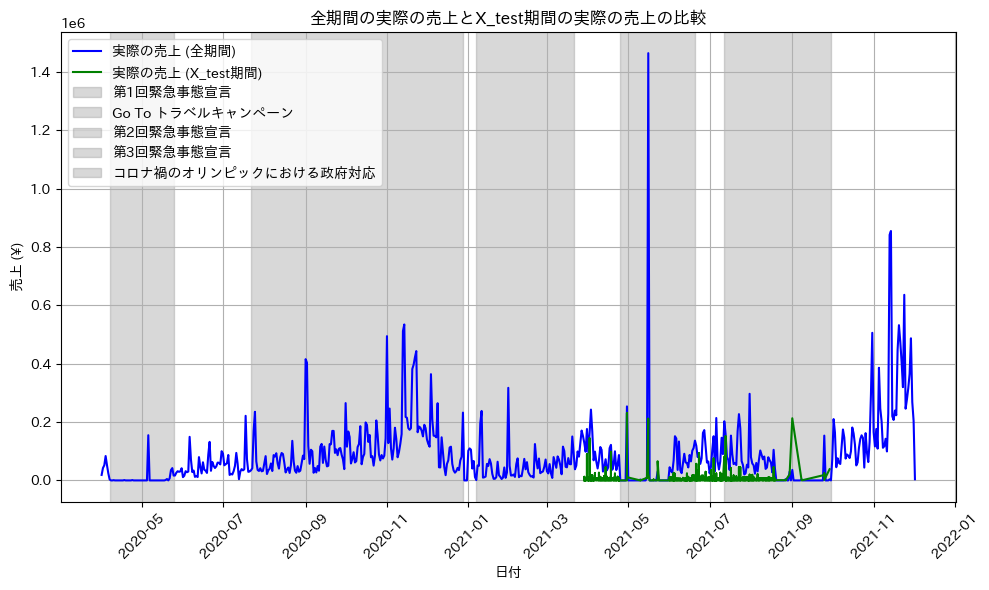

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 年, 月, 日 を使って '日付' 列を生成し、時間を追加
X_test['日付'] = pd.to_datetime(X_test['年'].astype(str) + '-' + X_test['月'].astype(str) + '-' + X_test['日'].astype(str))

# '日付' をインデックスに設定
X_test.set_index('日付', inplace=True)

# 3. 全期間の実際の売上データ (sales_data) を取得
# ここでは、sales_dataに '日付' がすでにインデックスとして存在していると仮定
actual_sales_all_period = data['売上'].resample('D').sum()

# 4. X_test期間の売上データを取得
actual_sales_test_period = X_test['売上']

# 5. グラフを描画
plt.figure(figsize=(10, 6))

# 全期間の実際の売上をプロット
plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')

# X_test期間の実際の売上をプロット
plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='実際の売上 (X_test期間)', color='green')

# 各イベント期間をグレーで背景に表示
for _, event in events_df.iterrows():
    plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])

# プロットの装飾
plt.title('全期間の実際の売上とX_test期間の実際の売上の比較')
plt.xlabel('日付')
plt.ylabel('売上 (¥)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# グラフを表示
plt.show()


### シミュレーション2（コロナ収束後）

In [ ]:
post_covid_data4prepared

,商品カテゴリ,商品ID,商品単価,数量,売上,年,月,日,時間
日付,,,,,,,,,
2021-10-01,4,28,600,1,600,2021,10,1,9
2021-10-01,1,87,0,1,0,2021,10,1,9
2021-10-01,1,105,0,1,0,2021,10,1,9
2021-10-01,4,28,600,2,1200,2021,10,1,9
2021-10-01,1,105,0,1,0,2021,10,1,9
...,...,...,...,...,...,...,...,...,...
2021-12-01,4,28,600,83,49800,2021,12,1,17
2021-12-01,0,73,200,33,6600,2021,12,1,17
2021-12-02,1,75,800,4,3200,2021,12,2,9


In [ ]:
learn_columns

['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

In [ ]:
# コロナ収束後のデータに基づいて説明変数を作成
X_post_covid = post_covid_data4prepared[learn_columns].copy()

# モデルを使って数量を予測
post_covid_data4prepared['予測数量'] = loaded_model.predict(X_post_covid, num_iteration=loaded_model.best_iteration)

# 予測された売上（予測数量 × 商品単価）
post_covid_data4prepared['予測売上'] = post_covid_data4prepared['予測数量'] * post_covid_data4prepared['商品単価']


<ipython-input-46-9a1e73c0e6b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data4prepared['予測数量'] = loaded_model.predict(X_post_covid, num_iteration=loaded_model.best_iteration)
<ipython-input-46-9a1e73c0e6b9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data4prepared['予測売上'] = post_covid_data4prepared['予測数量'] * post_covid_data4prepared['商品単価']


In [ ]:
learn_columns

['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

In [ ]:
# 実売上と予測売上の比較を表示
comparison = post_covid_data4prepared[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '売上', '予測売上']]
display(comparison.head())

# 実売上と予測売上の合計
total_actual_sales = post_covid_data4prepared['売上'].sum()
total_predicted_sales = post_covid_data4prepared['予測売上'].sum()

print(f"実売上の合計: {total_actual_sales:.2f}円")
print(f"予測売上の合計: {total_predicted_sales:.2f}円")


,商品カテゴリ,商品ID,商品単価,年,月,日,売上,予測売上
日付,,,,,,,,
2021-10-01,4,28,600,2021,10,1,600,1163.330253
2021-10-01,1,87,0,2021,10,1,0,0.000000
2021-10-01,1,105,0,2021,10,1,0,0.000000
2021-10-01,4,28,600,2021,10,1,1200,1163.330253
2021-10-01,1,105,0,2021,10,1,0,0.000000


実売上の合計: 13656820.00円
予測売上の合計: 14493348.82円


<ipython-input-49-a14f48327ba8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data['日付'] = pd.to_datetime(post_covid_data['年'].astype(str) + '-' + post_covid_data['月'].astype(str) + '-' + post_covid_data['日'].astype(str))


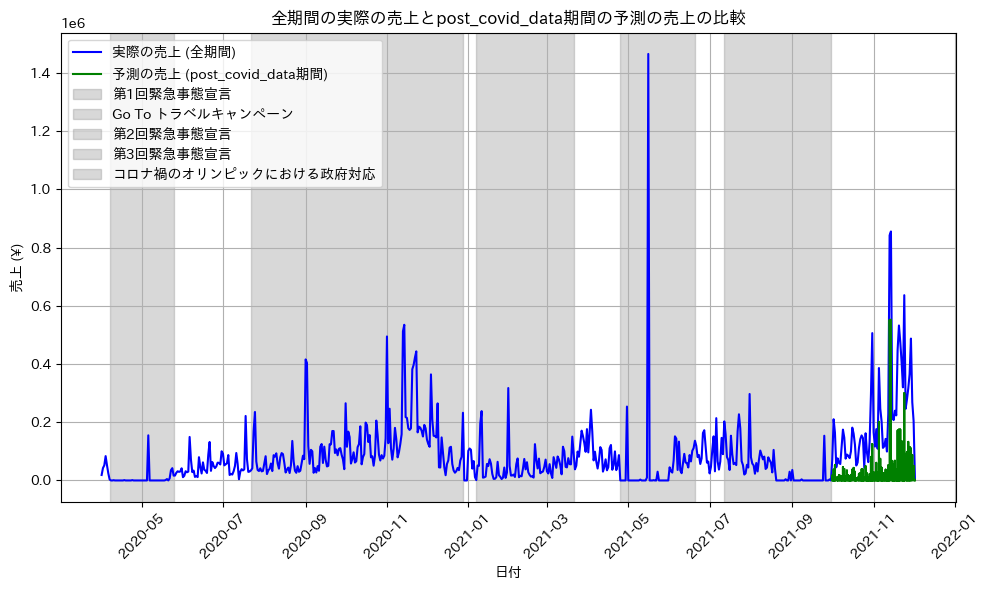

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 年, 月, 日 を使って '日付' 列を生成し、時間を追加
post_covid_data['日付'] = pd.to_datetime(post_covid_data['年'].astype(str) + '-' + post_covid_data['月'].astype(str) + '-' + post_covid_data['日'].astype(str))

# '日付' をインデックスに設定
post_covid_data.set_index('日付', inplace=True)

# 3. 全期間の実際の売上データ (sales_data) を取得
# ここでは、sales_dataに '日付' がすでにインデックスとして存在していると仮定
actual_sales_all_period = data['売上'].resample('D').sum()

# 4. X_test期間の売上データを取得
actual_sales_test_period = post_covid_data['売上']

# 5. グラフを描画
plt.figure(figsize=(10, 6))

# 全期間の実際の売上をプロット
plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')

# X_test期間の実際の売上をプロット
plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='予測の売上 (post_covid_data期間)', color='green')

# 各イベント期間をグレーで背景に表示
for _, event in events_df.iterrows():
    plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])

# プロットの装飾
plt.title('全期間の実際の売上とpost_covid_data期間の予測の売上の比較')
plt.xlabel('日付')
plt.ylabel('売上 (¥)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# グラフを表示
plt.show()


### シミュレーション3（高単価サービス値上げ）

In [ ]:
# 商品単価が0円の商品を除外
non_zero_price_data = covid_train_by_period[covid_train_by_period['商品単価'] > 0]

# 商品単価の上位20%を再定義
high_price_threshold = non_zero_price_data['商品単価'].quantile(0.8)

# 高単価サービスをフィルタリング
high_price_services = non_zero_price_data[non_zero_price_data['商品単価'] >= high_price_threshold]

# 高単価サービスの確認
display(high_price_services[['商品カテゴリ', '商品ID', '商品名', '商品単価']])

,商品カテゴリ,商品ID,商品名,商品単価
日付,,,,
2020-04-07,物販,8000216,植治の庭を歩いてみませんか,2200
2020-05-06,茶道,8000306,年会費（前期）,5000
2020-05-19,カフェ,8000298,クラフトビールセット,1000
2020-05-25,物販,8000215,シリーズ庭の巨匠たち2 植治,2620
2020-06-06,イベント,8000323,夜間イベント2500円,2500
...,...,...,...,...
2021-03-29,カフェ,8000324,喫茶 800円,800
2021-03-29,カフェ,8000324,喫茶 800円,800
2021-03-29,カフェ,8000324,喫茶 800円,800


In [ ]:
covid_test_by_period

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上,年,月,日,時間
日付,,,,,,,,,,,,,,
2021-03-29,2021-03-29 13:09:11,イベント,8000319,予約制入場手数料,200,NaN,1,2021-03-29,13:00:00,200,2021,3,29,13
2021-03-29,2021-03-29 13:10:51,入場料,8000181,入場料600円,600,NaN,3,2021-03-29,13:00:00,1800,2021,3,29,13
2021-03-29,2021-03-29 13:11:57,入場料,8000181,入場料600円,600,NaN,1,2021-03-29,13:00:00,600,2021,3,29,13
2021-03-29,2021-03-29 13:14:56,入場料,8000181,入場料600円,600,NaN,2,2021-03-29,13:00:00,1200,2021,3,29,13
2021-03-29,2021-03-29 13:15:15,カフェ,8000361,どら焼き 0円,0,NaN,1,2021-03-29,13:00:00,0,2021,3,29,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,2021-09-08 08:15:25,物販,8000422,紙袋,20,NaN,1,2021-09-08,08:00:00,20,2021,9,8,8
2021-09-25,2021-09-25 15:37:44,イベント,8000424,イベント_3800円,3800,NaN,27,2021-09-25,15:00:00,102600,2021,9,25,15
2021-09-25,2021-09-25 15:42:03,イベント,8000407,イベント_5000円,5000,NaN,10,2021-09-25,15:00:00,50000,2021,9,25,15


In [ ]:
# 商品単価が0円の商品を除外
non_zero_price_data = covid_train_by_period[covid_train_by_period['商品単価'] > 0]

# 平均 + 標準偏差1つ分を高単価の基準とする
mean_price = non_zero_price_data['商品単価'].mean()
std_price = non_zero_price_data['商品単価'].std()

# 高単価の基準を設定
high_price_threshold = mean_price + std_price

# 高単価サービスをフィルタリング
high_price_services = non_zero_price_data[non_zero_price_data['商品単価'] >= high_price_threshold]

# 高単価サービスの確認
display(high_price_services[['商品カテゴリ', '商品ID', '商品名', '商品単価']])


,商品カテゴリ,商品ID,商品名,商品単価
日付,,,,
2020-06-16,撮影料,8000024,撮影,30000
2020-06-21,撮影料,8000024,撮影,30000
2020-06-21,ガイド,8000342,庭園コンシェルジュ 日本語,11000
2020-06-30,撮影料,8000024,撮影,30000
2020-08-19,ガイド,8000342,庭園コンシェルジュ 日本語,11000
...,...,...,...,...
2021-01-17,イベント,8000387,イベント_15000円,15000
2021-01-28,茶道,8000310,初級,31740
2021-01-31,茶道,8000310,初級,31740


In [ ]:
high_price_services['商品単価'].min()

7800

In [ ]:
simulation_data

,商品カテゴリ,商品ID,商品単価,年,月,日,時間,売上
20752,0.0,54.0,200.0,2021.0,3.0,29.0,13.0,396.152925
20753,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20754,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20755,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20756,1.0,73.0,0.0,2021.0,3.0,29.0,13.0,0.000000
...,...,...,...,...,...,...,...,...
29510,5.0,91.0,22.0,2021.0,9.0,8.0,8.0,37.315589
29511,0.0,93.0,3800.0,2021.0,9.0,25.0,15.0,7116.178679
29512,0.0,82.0,5000.0,2021.0,9.0,25.0,15.0,9363.392998
29513,5.0,94.0,1100.0,2021.0,9.0,25.0,15.0,2376.438936


In [ ]:
simulation_data

,商品カテゴリ,商品ID,商品単価,年,月,日,時間,売上
20752,0.0,54.0,200.0,2021.0,3.0,29.0,13.0,396.152925
20753,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20754,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20755,3.0,17.0,600.0,2021.0,3.0,29.0,13.0,1148.096537
20756,1.0,73.0,0.0,2021.0,3.0,29.0,13.0,0.000000
...,...,...,...,...,...,...,...,...
29510,5.0,91.0,22.0,2021.0,9.0,8.0,8.0,37.315589
29511,0.0,93.0,3800.0,2021.0,9.0,25.0,15.0,7116.178679
29512,0.0,82.0,5000.0,2021.0,9.0,25.0,15.0,9363.392998
29513,5.0,94.0,1100.0,2021.0,9.0,25.0,15.0,2376.438936


In [ ]:
import numpy as np

# 高単価サービスのカテゴリリスト（例: ガイド、撮影料など）
high_price_categories = high_price_services['商品カテゴリ']  # 高単価サービスのカテゴリ名（文字列）

# シミュレーションデータの作成
simulation_data = X_test[learn_columns].copy()

# カテゴリ名を数値に変換して単価を10%増加
for category in high_price_categories:
    # '商品カテゴリ' のラベルエンコーダーを使用
    if category in label_encoders['商品カテゴリ'].classes_:  # ラベルエンコーダーにカテゴリが存在するかチェック
        category_label = label_encoders['商品カテゴリ'].transform([category])[0]  # カテゴリ名を数値化
        # 変換したカテゴリに対応する商品の単価を10%アップ
        simulation_data.loc[simulation_data['商品カテゴリ'] == category_label, '商品単価'] *= 1.1
    else:
        print(f"カテゴリ '{category}' がラベルエンコーダーに含まれていません。")

# シミュレーションデータで予測
pred_after = loaded_model.predict(simulation_data, num_iteration=loaded_model.best_iteration)

# 結果を表示
print(pred_after)


[ 1.83947664  1.86900653  1.86900653 ...  4.89017347  1.73424226
 10.11197165]


<ipython-input-56-9b4b07030395>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 33000.  33000.  33000.  33000.  33000.  33000.  33000. 110000.  33000.
  39600.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  simulation_data.loc[simulation_data['商品カテゴリ'] == category_label, '商品単価'] *= 1.1


In [ ]:
# 売上の計算 (数量 × 商品単価)
sales_before = covid_test_by_period['商品単価'] * covid_test_by_period['商品単価']
sales_after = simulation_data['商品単価'] * pred_after

# 売上の増減を計算
sales_change = sales_after.sum() - sales_before.sum()

print(f"施策前の総売上: {sales_before.sum():.2f}円")
print(f"施策後の総売上: {sales_after.sum():.2f}円")
print(f"売上の増減: {sales_change:.2f}円")

施策前の総売上: 40125751300.00円
施策後の総売上: 33667488.78円
売上の増減: -40092083811.22円


In [ ]:
# カテゴリごとの売上変化も確認
for category in high_price_categories:
    category_label = label_encoders['商品カテゴリ'].transform([category])[0]
    sales_before_category = sales_before[X_test['商品カテゴリ'] == category_label].sum()
    sales_after_category = sales_after[simulation_data['商品カテゴリ'] == category_label].sum()
    print(f"{category}の施策前売上: {sales_before_category:.2f}円, 施策後売上: {sales_after_category:.2f}円, 増減: {sales_after_category - sales_before_category:.2f}円")

撮影料の施策前売上: 18496000000.00円, 施策後売上: 2158746.76円, 増減: -18493841253.24円
撮影料の施策前売上: 18496000000.00円, 施策後売上: 2158746.76円, 増減: -18493841253.24円
ガイドの施策前売上: 584000000.00円, 施策後売上: 432615.21円, 増減: -583567384.79円
撮影料の施策前売上: 18496000000.00円, 施策後売上: 2158746.76円, 増減: -18493841253.24円
ガイドの施策前売上: 584000000.00円, 施策後売上: 432615.21円, 増減: -583567384.79円
一棟貸しの施策前売上: 0.00円, 施策後売上: 0.00円, 増減: 0.00円
ガイドの施策前売上: 584000000.00円, 施策後売上: 432615.21円, 増減: -583567384.79円
一棟貸しの施策前売上: 0.00円, 施策後売上: 0.00円, 増減: 0.00円
ガイドの施策前売上: 584000000.00円, 施策後売上: 432615.21円, 増減: -583567384.79円
茶道の施策前売上: 13617440000.00円, 施策後売上: 19921991.38円, 増減: -13597518008.62円
茶道の施策前売上: 13617440000.00円, 施策後売上: 19921991.38円, 増減: -13597518008.62円
イベントの施策前売上: 3745700000.00円, 施策後売上: 4337798.38円, 増減: -3741362201.62円
イベントの施策前売上: 3745700000.00円, 施策後売上: 4337798.38円, 増減: -3741362201.62円
茶道の施策前売上: 13617440000.00円, 施策後売上: 19921991.38円, 増減: -13597518008.62円
茶道の施策前売上: 13617440000.00円, 施策後売上: 19921991.38円, 増減: -13597518008.62円
ガイドの施策前売上: 584000000.00円, 施策後売上: 432615

In [ ]:
simulation_data['数量予測'] = pred_after
simulation_data['売上予測'] = simulation_data['数量予測'] * simulation_data['商品単価']
simulation_data['売上'] = X_test['売上']

In [ ]:
# コロナ収束後のデータに基づいて説明変数を作成
X_post_covid = post_covid_data4prepared[learn_columns].copy()

# モデルを使って数量を予測
post_covid_data4prepared['予測数量'] = loaded_model.predict(X_post_covid, num_iteration=loaded_model.best_iteration)

# 予測された売上（予測数量 × 商品単価）
post_covid_data4prepared['予測売上'] = post_covid_data4prepared['予測数量'] * post_covid_data4prepared['商品単価']


<ipython-input-60-9a1e73c0e6b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data4prepared['予測数量'] = loaded_model.predict(X_post_covid, num_iteration=loaded_model.best_iteration)
<ipython-input-60-9a1e73c0e6b9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_covid_data4prepared['予測売上'] = post_covid_data4prepared['予測数量'] * post_covid_data4prepared['商品単価']


In [ ]:
# 実売上と予測売上の比較を表示
comparison = post_covid_data4prepared[['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '売上', '予測売上']]
display(comparison.head())

# 実売上と予測売上の合計
total_actual_sales = post_covid_data4prepared['売上'].sum()
total_predicted_sales = post_covid_data4prepared['予測売上'].sum()

print(f"実売上の合計: {total_actual_sales:.2f}円")
print(f"予測売上の合計: {total_predicted_sales:.2f}円")

,商品カテゴリ,商品ID,商品単価,年,月,日,売上,予測売上
日付,,,,,,,,
2021-10-01,4,28,600,2021,10,1,600,1163.330253
2021-10-01,1,87,0,2021,10,1,0,0.000000
2021-10-01,1,105,0,2021,10,1,0,0.000000
2021-10-01,4,28,600,2021,10,1,1200,1163.330253
2021-10-01,1,105,0,2021,10,1,0,0.000000


実売上の合計: 13656820.00円
予測売上の合計: 14493348.82円


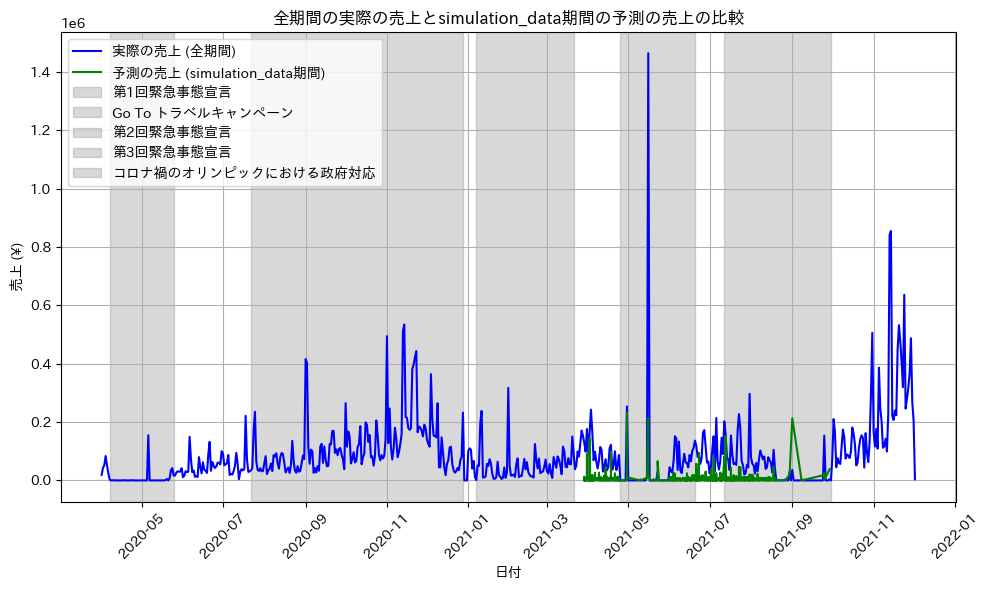

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 年, 月, 日 を使って '日付' 列を生成し、時間を追加
simulation_data['日付'] = pd.to_datetime(simulation_data['年'].astype(str) + '-' + simulation_data['月'].astype(str) + '-' + simulation_data['日'].astype(str))

# '日付' をインデックスに設定
simulation_data.set_index('日付', inplace=True)

# 3. 全期間の実際の売上データ (sales_data) を取得
# ここでは、sales_dataに '日付' がすでにインデックスとして存在していると仮定
actual_sales_all_period = data['売上'].resample('D').sum()

# 4. X_test期間の売上データを取得
actual_sales_test_period = simulation_data['売上']

# 5. グラフを描画
plt.figure(figsize=(10, 6))

# 全期間の実際の売上をプロット
plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')

# X_test期間の実際の売上をプロット
plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='予測の売上 (simulation_data期間)', color='green')

# 各イベント期間をグレーで背景に表示
for _, event in events_df.iterrows():
    plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])

# プロットの装飾
plt.title('全期間の実際の売上とsimulation_data期間の予測の売上の比較')
plt.xlabel('日付')
plt.ylabel('売上 (¥)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# グラフを表示
plt.show()


# 課題04-4

## ライブラリのインポート

In [ ]:
!pip install japanize_matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# データ処理と分析
import pandas as pd

# 機械学習用
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# グラフ描画と可視化
import matplotlib.pyplot as plt
import japanize_matplotlib  # matplotlibで日本語表示を可能にするライブラリ

# その他必要なライブラリがあれば追加


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
%%writefile my_custom_functions.py

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def calculate_total_sales(events, df):
    """
    各イベント期間中の売上を集計する関数。
    events: イベントのリスト（開始日と終了日を含む）
    df: 売上データが含まれるデータフレーム（日付がインデックス）
    """
    total_sales = []
    for event in events:
        event_period = df.loc[event['start']:event['end']]
        total_sales.append(event_period['売上'].sum())
    return total_sales

def plot_category_sales_pie(events, df):
    """
    イベント期間中の商品カテゴリ別売上割合を円グラフで表示する関数。
    events: イベントのリスト（開始日と終了日を含む）
    df: 売上データとカテゴリ情報が含まれるデータフレーム
    """
    for event in events:
        event_period = df.loc[event['start']:event['end']]
        category_sales = event_period.groupby('商品カテゴリ')['売上'].sum()
        plt.figure(figsize=(6, 6))
        plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=90)
        plt.title(f"{event['event']}期間のカテゴリ別売上割合")
        plt.show()

def plot_sales_comparison(actual_sales, predicted_sales, events_df):
    """
    実売上と予測売上を比較するグラフを描画する関数。
    actual_sales: 実際の売上データ（日付がインデックス）
    predicted_sales: 予測された売上データ（日付がインデックス）
    events_df: イベント情報を持つデータフレーム（開始日と終了日を含む）
    """
    plt.figure(figsize=(10, 6))
    plt.plot(actual_sales.index, actual_sales, label='実際の売上', color='blue')
    plt.plot(predicted_sales.index, predicted_sales, label='予測の売上', color='green')
    for _, event in events_df.iterrows():
        plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])
    plt.title('実際の売上と予測の売上の比較')
    plt.xlabel('日付')
    plt.ylabel('売上 (¥)')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def label_encoding_for_columns(df, columns):
    """
    指定された列をラベルエンコーディングする関数。
    df: データフレーム
    columns: ラベルエンコーディングを行う列のリスト
    """
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le  # エンコーダを保存
    return df, label_encoders

def simulate_price_increase(data, high_price_categories, label_encoders, price_increase=1.1):
    """
    高単価商品の価格を一定割合増加させたシミュレーションを行う関数。
    data: シミュレーション対象のデータフレーム
    high_price_categories: 高単価商品カテゴリのリスト
    label_encoders: カテゴリカル変数のラベルエンコーダ
    price_increase: 価格増加の倍率（デフォルトは10%増）
    """
    simulation_data = data.copy()
    for category in high_price_categories:
        if category in label_encoders['商品カテゴリ'].classes_:
            category_label = label_encoders['商品カテゴリ'].transform([category])[0]
            simulation_data.loc[simulation_data['商品カテゴリ'] == category_label, '商品単価'] *= price_increase
    return simulation_data

def compare_actual_and_predicted_sales(df, model, learn_columns):
    """
    実売上と予測売上の比較を行い、合計を表示する関数。
    df: 実売上と予測のためのデータフレーム
    model: 予測に使うモデル
    learn_columns: 説明変数のリスト
    """
    X_test = df[learn_columns].copy()
    df['予測数量'] = model.predict(X_test)
    df['予測売上'] = df['予測数量'] * df['商品単価']

    total_actual_sales = df['売上'].sum()
    total_predicted_sales = df['予測売上'].sum()

    print(f"実売上の合計: {total_actual_sales:.2f}円")
    print(f"予測売上の合計: {total_predicted_sales:.2f}円")

    return df


Writing my_custom_functions.py


In [ ]:
# my_custom_functions.py をインポート
from my_custom_functions import (
    calculate_total_sales,
    plot_category_sales_pie,
    plot_sales_comparison,
    label_encoding_for_columns,
    simulate_price_increase,
    compare_actual_and_predicted_sales
)

## データの読み込み

In [ ]:
# GitHubリポジトリからデータをクローン
!git clone https://github.com/Ry02024/24DXbyLifeIsTech.git

# データのディレクトリを指定
data_dir = "/content/24DXbyLifeIsTech/Data/preprocessed"

# ディレクトリの中身を確認
!ls {data_dir}

# sales_data_preprocessed2.csv を読み込む
sales_data = pd.read_csv(f"{data_dir}/data_sales_preprocessed2.csv")

# データの確認
display(sales_data.head())


Cloning into '24DXbyLifeIsTech'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 151 (delta 51), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 17.34 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (51/51), done.
data_sales_preprocessed2.csv  data_sales_preprocessed.csv  data_survey_preprocessed.csv


,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,日付,時間帯,売上
0,2020-04-01 09:32:25,入場料,8000181,入場料600円,600,NaN,8,2020-04-01,09:00:00,4800
1,2020-04-01 09:41:10,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,09:00:00,1200
2,2020-04-01 09:47:09,カフェ,8000152,セット 最中アイス・抹茶,900,266.0,1,2020-04-01,09:00:00,900
3,2020-04-01 09:47:09,入場料,8000181,入場料600円,600,NaN,1,2020-04-01,09:00:00,600
4,2020-04-01 10:16:25,入場料,8000181,入場料600円,600,NaN,2,2020-04-01,10:00:00,1200


In [ ]:
import pandas as pd
import yaml
from sklearn.preprocessing import LabelEncoder
import numpy as np

# --- 1. コロナ期間の開始日と終了日を指定 ---
start_of_covid = pd.to_datetime("2020-04-07")
end_of_covid = pd.to_datetime("2021-09-30")

# --- 2. sales_data の '日付' 列を日付形式に変換し、インデックスに設定 ---
sales_data['日付'] = pd.to_datetime(sales_data['日付'])
sales_data.set_index('日付', inplace=True)

# --- 3. コロナ期間中のデータを抽出 ---
covid_period_data = sales_data[(sales_data.index >= start_of_covid) & (sales_data.index <= end_of_covid)]

# --- 4. データを時系列順にソートし、後ろ30%のデータを X_test として抽出 ---
covid_period_data_sorted = covid_period_data.sort_index()
split_index = int(len(covid_period_data_sorted) * 0.7)
X_test = covid_period_data_sorted.iloc[split_index:]

# --- 5. config.yaml ファイルからラベルエンコーディング情報を取得 ---
base_dir = '/content/24DXbyLifeIsTech/'
with open(base_dir + '課題04/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

label_encoder_info = config['label_encoding']

# --- 6. 商品カテゴリをラベルエンコーディング ---
le = LabelEncoder()
le.classes_ = np.array(label_encoder_info['商品カテゴリ'])  # リストを numpy 配列に変換
X_test['商品カテゴリ'] = le.transform(X_test['商品カテゴリ'])

# 商品IDはカテゴリ型に変換
X_test['商品ID'] = X_test['商品ID'].astype('category')

# --- 7. '取引日時' 列を基に '年', '月', '日', '時間' の新しい列を作成 ---
X_test['取引日時'] = pd.to_datetime(X_test['取引日時'])
X_test['年'] = X_test['取引日時'].dt.year
X_test['月'] = X_test['取引日時'].dt.month
X_test['日'] = X_test['取引日時'].dt.day
X_test['時間'] = X_test['取引日時'].dt.hour

# --- 結果を確認 ---
X_test.head()


<ipython-input-6-c43e967806ba>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['商品カテゴリ'] = le.transform(X_test['商品カテゴリ'])
<ipython-input-6-c43e967806ba>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['商品ID'] = X_test['商品ID'].astype('category')
<ipython-input-6-c43e967806ba>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

,取引日時,商品カテゴリ,商品ID,商品名,商品単価,原価,数量,時間帯,売上,年,月,日,時間
日付,,,,,,,,,,,,,
2021-03-29,2021-03-29 13:09:11,0,8000319,予約制入場手数料,200,NaN,1,13:00:00,200,2021,3,29,13
2021-03-29,2021-03-29 13:10:51,4,8000181,入場料600円,600,NaN,3,13:00:00,1800,2021,3,29,13
2021-03-29,2021-03-29 13:11:57,4,8000181,入場料600円,600,NaN,1,13:00:00,600,2021,3,29,13
2021-03-29,2021-03-29 13:14:56,4,8000181,入場料600円,600,NaN,2,13:00:00,1200,2021,3,29,13
2021-03-29,2021-03-29 13:15:15,1,8000361,どら焼き 0円,0,NaN,1,13:00:00,0,2021,3,29,13


## モデル生成（読み込み）

### 学習（ラベルエンコーディング情報を取得するため）

In [ ]:
# import yaml

# # ラベルエンコーディングを行うカテゴリ列
# label_encoders = {}

# # 商品カテゴリと商品IDをエンコードし、その情報を保存
# for column in ['商品カテゴリ']:
#     le = LabelEncoder()
#     data[column] = le.fit_transform(data[column])
#     label_encoders[column] = le

# # ラベルエンコーダー情報をconfigファイル用に準備
# label_encoder_info = {}
# for column, encoder in label_encoders.items():
#     label_encoder_info[column] = list(encoder.classes_)

# # config.yaml に保存
# config = {
#     'label_encoding': label_encoder_info
# }

# with open('config.yaml', 'w') as file:
#     yaml.dump(config, file)


NameError: name 'data' is not defined

In [ ]:
import yaml

# configファイルからラベルエンコーディングの情報を読み込む
with open('/content/24DXbyLifeIsTech/課題04/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# 読み込んだラベルエンコーディング情報を使ってラベルエンコーダーを復元
label_encoders = {}
for column, classes in config['label_encoding'].items():
    le = LabelEncoder()
    le.classes_ = classes
    label_encoders[column] = le


In [ ]:
# # --- 3. モデルの学習 ---
# features = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']
# target = '数量'

# X_train = train_data[features]
# y_train = train_data[target]
# X_test = test_data[features]
# y_test = test_data[target]

# # LightGBMデータセットの作成
# train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=['商品カテゴリ', '商品ID'])
# valid_dataset = lgb.Dataset(X_test, label=y_test, categorical_feature=['商品カテゴリ', '商品ID'])

# # モデルパラメータ
# params = {
#     'objective': 'regression',
#     'metric': 'mae',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'feature_fraction': 0.9
# }

# # モデルの学習
# model = lgb.train(
#     params,
#     train_dataset,
#     valid_sets=[train_dataset, valid_dataset],
#     num_boost_round=1000,
#     callbacks=[log_evaluation(period=100), early_stopping(stopping_rounds=100)]
# )

# # --- 4. モデルとラベルエンコーディング情報の保存 ---

# # モデルを保存
# model.save_model('lightgbm_model.txt')

# # ラベルエンコーディング情報を config.yaml に保存
# config = {'label_encoding': label_encoder_info}

# with open('config.yaml', 'w') as file:
#     yaml.dump(config, file)

# print("モデルとラベルエンコーディング情報を保存しました。")

### モデルの読み込み

In [ ]:
import lightgbm as lgb

# 保存したモデルファイルのパス
model_dir = '/content/24DXbyLifeIsTech/課題04/'
model_filename = 'lightgbm_model.txt'

# 保存されたモデルをLightGBMのBoosterオブジェクトとして読み込む
loaded_model = lgb.Booster(model_file=model_dir+model_filename)

# モデルの確認（オプション）
print("モデルが正しく読み込まれました。")


モデルが正しく読み込まれました。


## シミュレーション

### シミュレーションの準備

ラベルエンコーディング

### シミュレーション1：X_test期間（コロナ期間の後ろの30%）の精度確認

In [ ]:
base_dir = '/content/24DXbyLifeIsTech/'

In [ ]:
learn_columns = ['商品カテゴリ', '商品ID', '商品単価', '年', '月', '日', '時間']

In [ ]:
import yaml
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# --- 3. モデルによる予測 ---
# 予測を行う
y_pred = loaded_model.predict(X_test[learn_columns])

# 予測結果を使用して売上を計算
X_test['売上予測'] = y_pred * X_test['商品単価']

# 結果を確認
print(X_test[['商品カテゴリ', '商品ID', '商品単価', '売上予測']].head())


            商品カテゴリ     商品ID  商品単価        売上予測
日付                                           
2021-03-29       0  8000319   200  678.592540
2021-03-29       4  8000181   600  936.310331
2021-03-29       4  8000181   600  936.310331
2021-03-29       4  8000181   600  936.310331
2021-03-29       1  8000361     0    0.000000


<ipython-input-13-d9c1a907774a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['売上予測'] = y_pred * X_test['商品単価']


In [ ]:
covid_events = [
    {"event": "第1回緊急事態宣言", "start": "2020-04-07", "end": "2020-05-25"},
    {"event": "Go To トラベルキャンペーン", "start": "2020-07-22", "end": "2020-12-28"},
    {"event": "第2回緊急事態宣言", "start": "2021-01-07", "end": "2021-03-21"},
    {"event": "第3回緊急事態宣言", "start": "2021-04-25", "end": "2021-06-20"},
    {"event": "コロナ禍のオリンピックにおける政府対応", "start": "2021-07-12", "end": "2021-09-30"}
]

# Convert the event start and end dates to datetime
for event in covid_events:
    event['start'] = pd.to_datetime(event['start'])
    event['end'] = pd.to_datetime(event['end'])

# Determine the earliest and latest dates of the events
events_df = pd.DataFrame(covid_events)

<ipython-input-15-d6b4ffe35bd4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['日付'] = pd.to_datetime(X_test['年'].astype(str) + '-' + X_test['月'].astype(str) + '-' + X_test['日'].astype(str))


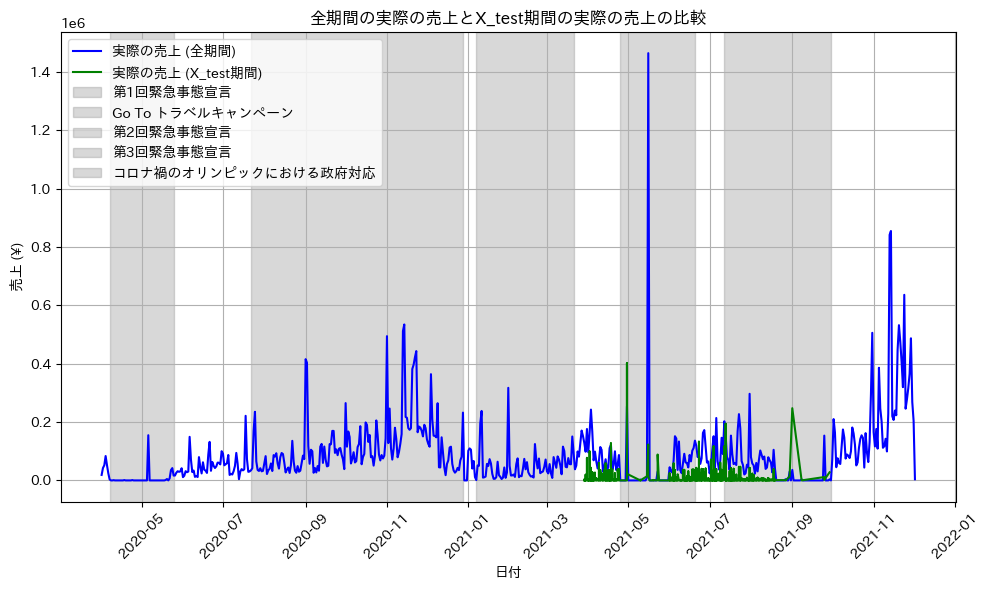

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. '日付' 列を作成
X_test['日付'] = pd.to_datetime(X_test['年'].astype(str) + '-' + X_test['月'].astype(str) + '-' + X_test['日'].astype(str))

# 2. '日付' をインデックスに設定
X_test.set_index('日付', inplace=True)

# 日次で売上を集計
actual_sales_all_period = sales_data['売上'].resample('D').sum()

# 4. X_test期間の売上データを取得
# X_test に '売上' 列が存在しているか確認
if '売上予測' not in X_test.columns:
    raise ValueError("'X_test' に '売上' 列がありません。予測された '売上' を含む列を追加してください。")

actual_sales_test_period = X_test['売上予測']

# 5. グラフを描画
plt.figure(figsize=(10, 6))

# 全期間の実際の売上をプロット
plt.plot(actual_sales_all_period.index, actual_sales_all_period, label='実際の売上 (全期間)', color='blue')

# X_test期間の実際の売上をプロット
plt.plot(actual_sales_test_period.index, actual_sales_test_period, label='実際の売上 (X_test期間)', color='green')

# 各イベント期間をグレーで背景に表示
for _, event in events_df.iterrows():
    plt.axvspan(event['start'], event['end'], color='gray', alpha=0.3, label=event['event'])

# プロットの装飾
plt.title('全期間の実際の売上とX_test期間の実際の売上の比較')
plt.xlabel('日付')
plt.ylabel('売上 (¥)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# グラフを表示
plt.show()


### シミュレーション2：コロナ収束後の予測

### シミュレーション3：高単価サービス値上げのシミュレーション

## Configファイルの作り方

config ファイルは、プロジェクトの進行に伴い、段階的に設定項目が追加・更新されます。初期段階ではデータパスや基本的なパラメータの定義に始まり、データ処理、モデルチューニング、シミュレーションなどプロジェクトの各段階に応じて、必要な設定を順次追加していきます。

初期段階: データパスや期間設定など基本的なパラメータを設定。  
データ前処理段階: 特徴量やカテゴリ変数など、データの詳細が確定したら追加。  
モデルチューニング段階: ハイパーパラメータやクロスバリデーションなど、モデルに関連する設定を更新。  
シミュレーションや評価段階: シミュレーション条件や評価設定を追加。
このように、プロジェクトの進行に応じて柔軟に config ファイルを作成・更新していくことが重要です。  

### YAML形式のconfig ファイル作成例

In [ ]:
# データパス設定
data:
  input_path: "/content/24DXbyLifeIsTech/Data/preprocessed/data_sales_preprocessed2.csv"

# コロナ関連の設定
covid:
  start_date: "2020-04-07"
  end_date: "2021-09-30"

# モデルの学習設定
model:
  learning_rate: 0.05
  num_leaves: 31
  boosting_type: "gbdt"
  objective: "regression"
  metric: "mae"
  feature_fraction: 0.9
  num_boost_round: 1000
  early_stopping_rounds: 500
  evaluation_period: 100

# 予測に使用するカラム（特徴量）
features:
  - "商品カテゴリ"
  - "商品ID"
  - "商品単価"
  - "年"
  - "月"
  - "日"
  - "時間"

# カテゴリ変数設定
label_encoding_columns:
  - "商品カテゴリ"
  - "商品ID"

# シミュレーション設定
simulation:
  high_price_threshold_quantile: 0.8  # 高単価商品の閾値の分位
  price_increase_rate: 1.1  # シミュレーションでの価格増加率


### YAMLファイルの読み込み方法

In [ ]:
import yaml

# config.yaml を読み込む
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# configの確認
print(config)

# 例: データパスを取得
data_path = config['data']['input_path']
print(f"データパス: {data_path}")

# 例: モデルの学習設定を取得
learning_rate = config['model']['learning_rate']
num_leaves = config['model']['num_leaves']
print(f"Learning Rate: {learning_rate}, Num Leaves: {num_leaves}")


`config` ファイルは、データ分析や機械学習プロジェクトを進める過程で、設定値やパラメータの一元管理を行うために作成されます。プロジェクトの初期段階では明確に定義されていないパラメータも、プロジェクトの進行とともに追加・変更されていきます。

**`config` ファイルの作成プロセス**  

`config` ファイルは、以下のステップに従って作成・更新されます。

---

1. **プロジェクトの初期段階: パラメータや設定の決定**

プロジェクトの初期段階では、以下のような基本的なパラメータが決まることが多いです。

- **データのパスやフォルダ構造**  
  データの保存場所が決まった段階で、`config` ファイルにデータパスを記載します。例えば、データのファイル名やフォルダ構造を明確にするために、プロジェクトのディレクトリ構造が整ったら、その情報を追加します。

- **データの期間設定**  
  分析対象のデータ期間（例: コロナ期間や特定のイベント期間）が確定した段階で、`config` に期間設定を追加します。

- **ハイパーパラメータの仮設定**  
  モデルのハイパーパラメータは、最初は仮の値を設定します。例えば、`learning_rate` や `num_leaves` などを設定し、トレーニングを進める中で調整します。

**最初の `config.yaml` の例**

```yaml
# データパス設定
data:
  input_path: "/path/to/data.csv"

# コロナ関連の設定
covid:
  start_date: "2020-04-07"
  end_date: "2021-09-30"

# モデルの仮設定
model:
  learning_rate: 0.05
  num_leaves: 31
  boosting_type: "gbdt"
  objective: "regression"
  metric: "mae"
```

---

2. **データ処理・前処理の段階**

データの前処理段階で、データの特徴量やカラム名などが確定していきます。また、カテゴリカルデータのラベルエンコーディングなどの処理も必要になります。これに応じて、`config` ファイルに以下のような設定を追加します。

- **使用する特徴量**  
  モデルに使用する特徴量のカラム名が確定したら、それを `config` に追加します。

- **カテゴリカルデータの設定**  
  ラベルエンコーディングが必要なカテゴリ変数を `config` に追加します。

- **データ分割のパラメータ**  
  トレーニングデータとテストデータの分割比率やクロスバリデーションの設定などが必要であれば、その設定を `config` に追加します。

**データ前処理段階の `config.yaml` の例**

```yaml
# データパス設定
data:
  input_path: "/path/to/data.csv"

# コロナ関連の設定
covid:
  start_date: "2020-04-07"
  end_date: "2021-09-30"

# モデルの仮設定
model:
  learning_rate: 0.05
  num_leaves: 31
  boosting_type: "gbdt"
  objective: "regression"
  metric: "mae"

# 特徴量の設定
features:
  - "商品カテゴリ"
  - "商品ID"
  - "商品単価"
  - "年"
  - "月"
  - "日"
  - "時間"

# カテゴリ変数設定
label_encoding_columns:
  - "商品カテゴリ"
  - "商品ID"
```

---

3. **モデルのトレーニング・チューニングの段階**

モデルのトレーニングを進める中で、以下のような追加のパラメータが決まります。

- **ハイパーパラメータの調整**  
  学習率 (`learning_rate`) や木の深さ (`max_depth`) など、ハイパーパラメータをチューニングする際、試した設定値を `config` に記録します。最終的な最適パラメータが見つかれば、`config` を更新します。

- **クロスバリデーションの設定**  
  データを分割して検証する際の設定（例: K-foldの分割数など）も追加します。

**モデルチューニング段階の `config.yaml` の例**

```yaml
# モデルのハイパーパラメータ設定
model:
  learning_rate: 0.01  # 学習率を調整
  num_leaves: 50  # num_leavesを調整
  boosting_type: "gbdt"
  objective: "regression"
  metric: "mae"
  feature_fraction: 0.8  # 特徴量のランダム選択割合
  num_boost_round: 2000
  early_stopping_rounds: 100
  evaluation_period: 100
```

---

4. **シミュレーションやモデル評価の段階**

シミュレーションや評価を行う際に、以下の設定を追加します。

- **シミュレーションのパラメータ**  
  例えば、価格増加のシミュレーションを行う場合、価格の増加率や対象商品の設定を `config` に追加します。

- **モデル評価の設定**  
  評価基準や検証期間、スコアの記録場所など、評価に関連するパラメータもここで管理します。

**シミュレーション段階の `config.yaml` の例**

```yaml
# シミュレーション設定
simulation:
  high_price_threshold_quantile: 0.8  # 高単価商品の閾値（上位20%）
  price_increase_rate: 1.1  # 価格を10%増加

# 評価設定
evaluation:
  k_fold: 5  # クロスバリデーションの分割数
  validation_split: 0.2  # 検証データの分割比率
```

---

**まとめ**

`config` ファイルは、プロジェクトの進行に伴い、段階的に設定項目が追加・更新されます。初期段階ではデータパスや基本的なパラメータの定義に始まり、データ処理、モデルチューニング、シミュレーションなどプロジェクトの各段階に応じて、必要な設定を順次追加していきます。

- **初期段階**: データパスや期間設定など基本的なパラメータを設定。
- **データ前処理段階**: 特徴量やカテゴリ変数など、データの詳細が確定したら追加。
- **モデルチューニング段階**: ハイパーパラメータやクロスバリデーションなど、モデルに関連する設定を更新。
- **シミュレーションや評価段階**: シミュレーション条件や評価設定を追加。

このように、プロジェクトの進行に応じて柔軟に `config` ファイルを作成・更新していくことが重要です。